## Dataset Setup (UTKFace)

This notebook uses the [UTKFace dataset](https://susanqq.github.io/UTKFace/).

Please download the dataset manually from one of the sources (e.g., official site, Kaggle mirrors), then extract it into a folder named `gender_age_dataset` in the same directory as this notebook.


In [4]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import torchvision
from sklearn.metrics import precision_recall_fscore_support
import json

In [5]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [6]:
class GenderDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return image, label


In [7]:
# Function to extract gender labels from filename
def extract_gender_labels_from_filename(filename):
    parts = filename.split('_')
    if len(parts) < 3:
        return None
    try:
        return int(parts[1])
    except ValueError:
        return None

# Function to load dataset
def load_gender_dataset(dataset_dir):
    images = []
    labels = []

    for subdir in os.listdir(dataset_dir):
        subdir_path = os.path.join(dataset_dir, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith(".jpg"):
                    gender = extract_gender_labels_from_filename(filename)
                    if gender is None:
                        continue
                    image_path = os.path.join(subdir_path, filename)
                    images.append(image_path)
                    labels.append(gender)

    return images, labels

In [ ]:
dataset_dir = './gender_age_dataset/'
images, labels = load_gender_dataset(dataset_dir)

# Split dataset into train, validation, and test
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [9]:
# Data transformation (normalization and resizing)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),    # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=45),     # Randomly rotate the image within 45 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained mean and std
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained mean and std
])

In [10]:
# Create datasets and dataloaders
train_dataset = GenderDataset(train_images, train_labels, transform=train_transform)
val_dataset = GenderDataset(val_images, val_labels, transform=train_transform)
test_dataset = GenderDataset(test_images, test_labels, transform=test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

Training samples: 14463, Validation samples: 4821, Test samples: 4821


In [11]:
batch , label = train_dataset[0]
batch.shape

torch.Size([3, 224, 224])

In [12]:

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)  # Reshape to match image dimensions
    std = torch.tensor(std).view(1, 3, 1, 1)
    return tensor * std + mean


# Gender label mapping
gender_labels = {0: 'Male', 1: 'Female'}

def visualize_images(data_loader, num_images=8, gender_labels={0: 'Male', 1: 'Female'}):
    import matplotlib.pyplot as plt
    import numpy as np

    # Get a batch of images and labels
    inputs, labels = next(iter(data_loader))

    # Denormalize images
    mean = [0.485, 0.456, 0.406]  # Same as used in transforms.Normalize
    std = [0.229, 0.224, 0.225]
    inputs = denormalize(inputs, mean, std)

    # Convert to numpy for visualization
    inputs = inputs.permute(0, 2, 3, 1).numpy()  # Rearrange dimensions to [batch, height, width, channels]

    # Clip values to valid range for visualization
    inputs = np.clip(inputs, 0, 1)

    # Plot the images with labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(inputs[i])
        ax.axis('off')

        # Get the gender label (0 or 1) and map it to 'Male' or 'Female'
        label = labels[i].item()  # Convert tensor to scalar (0 or 1)
        gender = gender_labels.get(label, 'Unknown')  # Get the gender label from the dictionary
        ax.set_title(f'Gender: {gender}')  # Add gender label as title

    plt.show()




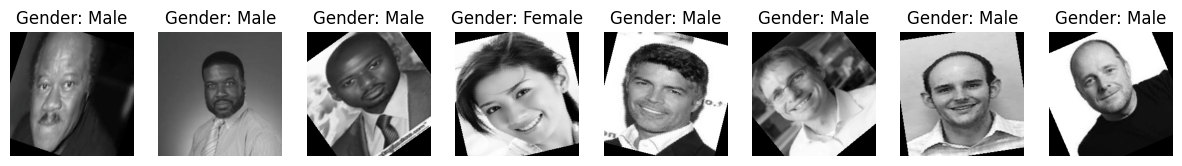

In [13]:
visualize_images(train_loader, num_images=8)

In [14]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 206MB/s]


In [15]:
!pip install torchinfo

In [16]:
from enum import auto
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 1000]         --                 True
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 32, 112, 112] --                 True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 32, 112, 112] 864                True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64                 True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                 True
│    │    └─M

In [ ]:
# Freeze all parameters in the feature layers
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1)

).to(device)

In [ ]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=True
)

In [20]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

from sklearn.metrics import precision_recall_fscore_support

def precision_recall(output, target):
    # Detach tensors from the computation graph before converting to numpy
    pred = output.detach().round()  # Detach from computation graph and round

    # Calculate precision and recall using sklearn's function
    precision, recall, _, _ = precision_recall_fscore_support(
        target.cpu().numpy(),
        pred.cpu().numpy(),
        average='weighted',
        zero_division=0
    )

    return precision, recall


# Gradient clipping function
def clip_gradient(optimizer, grad_clip=1.0):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [23]:

# Initialize lists for tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 60
best_val_loss=float('inf')
early_stopping_patience=5
best_model_path='gender_model.pth'
metrics_path='training_metrics.json'

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_precision = 0.0
    running_recall = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            y_logits = model(inputs).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits, labels)

            loss.backward()
            clip_gradient(optimizer)  # Gradient clipping
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += accuracy_fn(labels, y_pred) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(y_pred, labels)
        running_precision += batch_precision * inputs.size(0)
        running_recall += batch_recall * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    epoch_precision = running_precision / len(train_dataset)
    epoch_recall = running_recall / len(train_dataset)

    print(f'Training - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_precision = 0.0
    val_running_recall = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)


            y_logits = model(inputs).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += accuracy_fn(labels, y_pred) * inputs.size(0)
            batch_precision, batch_recall = precision_recall(y_pred, labels)
            val_running_precision += batch_precision * inputs.size(0)
            val_running_recall += batch_recall * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects / len(val_dataset)
    val_precision = val_running_precision / len(val_dataset)
    val_recall = val_running_recall / len(val_dataset)

    print(f'Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

    # Save the metrics to a file after each epoch
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    train_accuracies.append(epoch_acc)
    val_accuracies.append(val_acc)

    with open(metrics_path, 'w') as f:
        json.dump({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }, f)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping and model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with validation loss: {val_loss:.4f}')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break

print('Training completed')



Epoch 1/60
----------
Training - Loss: 0.4568 Acc: 78.0613 Precision: 0.7989 Recall: 0.7806
Validation - Loss: 0.4159 Acc: 80.0249 Precision: 0.8088 Recall: 0.8002
Saved best model with validation loss: 0.4159

Epoch 2/60
----------
Training - Loss: 0.4526 Acc: 78.6006 Precision: 0.8055 Recall: 0.7860
Validation - Loss: 0.4137 Acc: 80.5435 Precision: 0.8218 Recall: 0.8054
Saved best model with validation loss: 0.4137

Epoch 3/60
----------
Training - Loss: 0.4488 Acc: 78.7803 Precision: 0.8042 Recall: 0.7878
Validation - Loss: 0.4152 Acc: 80.4397 Precision: 0.8176 Recall: 0.8044

Epoch 4/60
----------
Training - Loss: 0.4441 Acc: 78.8080 Precision: 0.8047 Recall: 0.7881
Validation - Loss: 0.4066 Acc: 80.7301 Precision: 0.8163 Recall: 0.8073
Saved best model with validation loss: 0.4066

Epoch 5/60
----------
Training - Loss: 0.4422 Acc: 79.3404 Precision: 0.8098 Recall: 0.7934
Validation - Loss: 0.4057 Acc: 80.6264 Precision: 0.8152 Recall: 0.8063
Saved best model with validation loss

In [28]:
# Test phase
model.eval()  # Set the model to evaluation mode
test_running_loss = 0.0
test_running_corrects = 0
test_running_precision = 0.0
test_running_recall = 0.0

with torch.no_grad():  # No gradients needed for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        y_logits = model(inputs).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, labels)

        test_running_loss += loss.item() * inputs.size(0)  # Accumulate loss
        test_running_corrects += accuracy_fn(labels, y_pred) * inputs.size(0)  # Calculate accuracy
        batch_precision, batch_recall = precision_recall(y_pred, labels)
        test_running_precision += batch_precision * inputs.size(0)
        test_running_recall += batch_recall * inputs.size(0)

# Calculate average metrics
test_loss = test_running_loss / len(test_dataset)
test_acc = test_running_corrects / len(test_dataset)
test_precision = test_running_precision / len(test_dataset)
test_recall = test_running_recall / len(test_dataset)

# Print test results
print(f'Test - Loss: {test_loss:.4f} Acc: {test_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')


Test - Loss: 0.3913 Acc: 81.8710 Precision: 0.8284 Recall: 0.8187


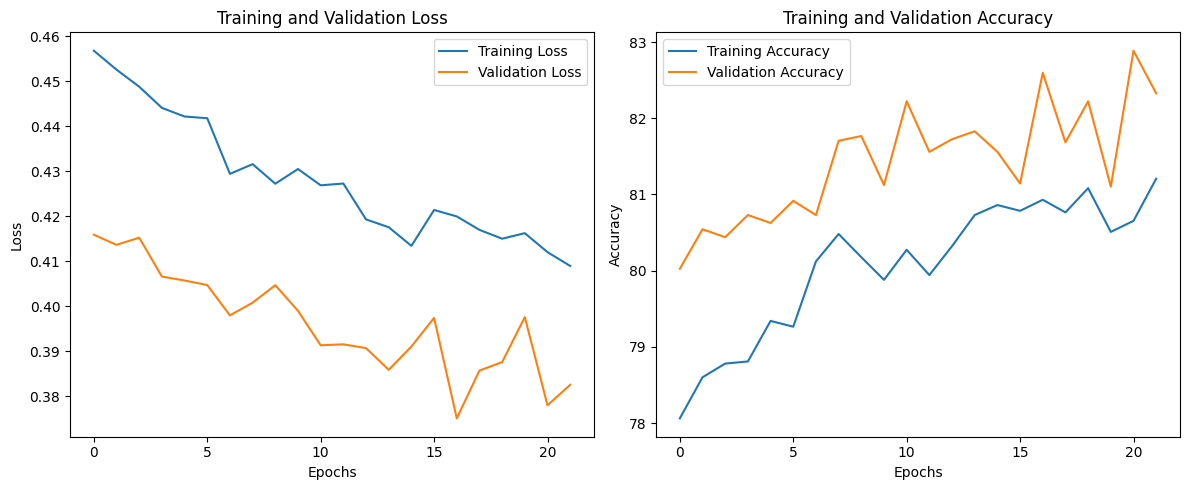

In [ ]:
import json
import matplotlib.pyplot as plt

# Load saved metrics
with open('./training_metrics.json', 'r') as f:
    metrics = json.load(f)

# Extract lists
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
train_accuracies = metrics['train_accuracies']
val_accuracies = metrics['val_accuracies']

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
# Fine-tuning preparation
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True


In [ ]:
# Adjust learning rate for fine-tuning
fine_tune_lr = 1e-4  # Lower learning rate for fine-tuning
fine_tune_optimizer = torch.optim.Adam(model.parameters(), lr=fine_tune_lr)

# Learning rate scheduler for fine-tuning
fine_tune_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    fine_tune_optimizer,
    mode='min',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=True
)


In [33]:
# Fine-tuning metrics tracking lists
fine_tune_train_losses = []
fine_tune_val_losses = []
fine_tune_train_accuracies = []
fine_tune_val_accuracies = []
fine_tune_metrics_path = 'fine_tuning_metrics.json'

# Fine-tuning hyperparameters
fine_tune_epochs = 40
fine_tune_patience = 5
best_fine_tune_val_loss = float('inf')
fine_tune_epochs_without_improvement = 0
fine_tune_best_model_path = 'fine_tuned_gender_model.pth'

# Fine-tuning training loop
for epoch in range(fine_tune_epochs):
    print(f'\nFine-tuning Epoch {epoch + 1}/{fine_tune_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_precision = 0.0
    running_recall = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        fine_tune_optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            y_logits = model(inputs).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits, labels)

            loss.backward()
            clip_gradient(fine_tune_optimizer)  # Gradient clipping
            fine_tune_optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += accuracy_fn(labels, y_pred) * inputs.size(0)
        batch_precision, batch_recall = precision_recall(y_pred, labels)
        running_precision += batch_precision * inputs.size(0)
        running_recall += batch_recall * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    epoch_precision = running_precision / len(train_dataset)
    epoch_recall = running_recall / len(train_dataset)

    print(f'Fine-tuning Training - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    val_running_precision = 0.0
    val_running_recall = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            y_logits = model(inputs).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += accuracy_fn(labels, y_pred) * inputs.size(0)
            batch_precision, batch_recall = precision_recall(y_pred, labels)
            val_running_precision += batch_precision * inputs.size(0)
            val_running_recall += batch_recall * inputs.size(0)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects / len(val_dataset)
    val_precision = val_running_precision / len(val_dataset)
    val_recall = val_running_recall / len(val_dataset)

    print(f'Fine-tuning Validation - Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

    # Save the metrics to a file after each epoch
    fine_tune_train_losses.append(epoch_loss)
    fine_tune_val_losses.append(val_loss)
    fine_tune_train_accuracies.append(epoch_acc)
    fine_tune_val_accuracies.append(val_acc)

    with open(fine_tune_metrics_path, 'w') as f:
        json.dump({
            'fine_tune_train_losses': fine_tune_train_losses,
            'fine_tune_val_losses': fine_tune_val_losses,
            'fine_tune_train_accuracies': fine_tune_train_accuracies,
            'fine_tune_val_accuracies': fine_tune_val_accuracies
        }, f)

    # Learning rate scheduling
    fine_tune_scheduler.step(val_loss)

    # Early stopping and model checkpoint
    if val_loss < best_fine_tune_val_loss:
        best_fine_tune_val_loss = val_loss
        fine_tune_epochs_without_improvement = 0
        torch.save(model.state_dict(), fine_tune_best_model_path)
        print(f'Saved best fine-tuned model with validation loss: {val_loss:.4f}')
    else:
        fine_tune_epochs_without_improvement += 1

    if fine_tune_epochs_without_improvement >= fine_tune_patience:
        print(f'Early stopping triggered after {epoch + 1} fine-tuning epochs')
        break

print('Fine-tuning completed')




Fine-tuning Epoch 1/40
----------
Fine-tuning Training - Loss: 0.3554 Acc: 84.6643 Precision: 0.8591 Recall: 0.8466
Fine-tuning Validation - Loss: 0.3022 Acc: 87.0151 Precision: 0.8766 Recall: 0.8702
Saved best fine-tuned model with validation loss: 0.3022

Fine-tuning Epoch 2/40
----------
Fine-tuning Training - Loss: 0.2848 Acc: 88.0039 Precision: 0.8901 Recall: 0.8800
Fine-tuning Validation - Loss: 0.2683 Acc: 88.6123 Precision: 0.8927 Recall: 0.8861
Saved best fine-tuned model with validation loss: 0.2683

Fine-tuning Epoch 3/40
----------
Fine-tuning Training - Loss: 0.2458 Acc: 89.9329 Precision: 0.9091 Recall: 0.8993
Fine-tuning Validation - Loss: 0.2633 Acc: 88.6538 Precision: 0.8949 Recall: 0.8865
Saved best fine-tuned model with validation loss: 0.2633

Fine-tuning Epoch 4/40
----------
Fine-tuning Training - Loss: 0.2130 Acc: 91.4057 Precision: 0.9215 Recall: 0.9141
Fine-tuning Validation - Loss: 0.2501 Acc: 89.5872 Precision: 0.9005 Recall: 0.8959
Saved best fine-tuned mod

In [34]:
# Test phase
model.eval()  # Set the model to evaluation mode
test_running_loss = 0.0
test_running_corrects = 0
test_running_precision = 0.0
test_running_recall = 0.0

with torch.no_grad():  # No gradients needed for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        y_logits = model(inputs).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, labels)


        test_running_loss += loss.item() * inputs.size(0)  # Accumulate loss
        test_running_corrects += accuracy_fn(labels, y_pred) * inputs.size(0)  # Calculate accuracy
        batch_precision, batch_recall = precision_recall(y_pred, labels)
        test_running_precision += batch_precision * inputs.size(0)
        test_running_recall += batch_recall * inputs.size(0)

# Calculate average metrics
test_loss = test_running_loss / len(test_dataset)
test_acc = test_running_corrects / len(test_dataset)
test_precision = test_running_precision / len(test_dataset)
test_recall = test_running_recall / len(test_dataset)

# Print test results
print(f'Test - Loss: {test_loss:.4f} Acc: {test_acc:.4f} Precision: {test_precision:.4f} Recall: {test_recall:.4f}')


Test - Loss: 0.2526 Acc: 92.3045 Precision: 0.9272 Recall: 0.9230


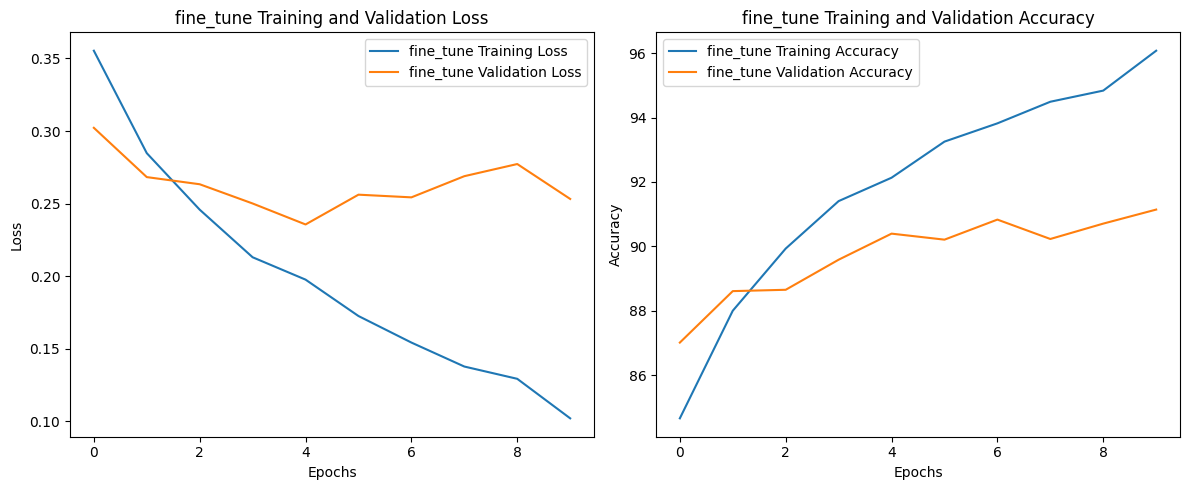

In [35]:
import json
import matplotlib.pyplot as plt

# Load saved metrics
with open('/content/fine_tuning_metrics.json', 'r') as f:
    metrics = json.load(f)

# Extract lists
train_losses = metrics['fine_tune_train_losses']
val_losses = metrics['fine_tune_val_losses']
train_accuracies = metrics['fine_tune_train_accuracies']
val_accuracies = metrics['fine_tune_val_accuracies']

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='fine_tune Training Loss')
plt.plot(val_losses, label='fine_tune Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('fine_tune Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='fine_tune Training Accuracy')
plt.plot(val_accuracies, label='fine_tune Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('fine_tune Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
